# Footprint Pressure Heatmap (단일 노트북 버전)

발바닥 RGB Footprint 이미지를 입력으로 받아, **왜곡이 최소화된 파란 계열 압력 히트맵**을 생성하는 전체 코드를
이 노트북 하나에 모두 정리했습니다.

- Jet 컬러맵으로 인한 과도한 왜곡 대신, 단일 파란 계열 컬러맵(`pressure_blue`)을 사용합니다.
- Raw Pressure Heatmap과 (옵션) 히스토그램 평탄화(Equalized) 결과를 함께 확인할 수 있습니다.


In [80]:
import os
from pathlib import Path
from typing import Optional, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


# Jet 팔레트 RGB 캐시
_JET_RGB_LOOKUP: Optional[np.ndarray] = None


## 1. 이미지 로딩 및 Jet → 스칼라 변환 함수


In [81]:
def _get_jet_rgb_lookup() -> np.ndarray:
    """Jet 컬러맵의 256단계 RGB 값을 미리 계산해서 캐시합니다.

    Returns
    -------
    np.ndarray
        shape = (256, 3), dtype = float32, 각 행은 [R, G, B] (0~255 범위).
    """
    global _JET_RGB_LOOKUP
    if _JET_RGB_LOOKUP is None:
        cmap = plt.get_cmap("jet", 256)
        _JET_RGB_LOOKUP = (
            cmap(np.linspace(0, 1, 256))[:, :3] * 255.0
        ).astype(np.float32)
    return _JET_RGB_LOOKUP


def jet_rgb_to_intensity(rgb_image: np.ndarray) -> np.ndarray:
    """Jet 컬러 이미지(RGB)를 0~255 스칼라 강도 맵으로 역변환합니다.

    각 픽셀의 RGB를 Jet 팔레트 256단계 중 가장 가까운 색의 인덱스로 치환합니다.
    """
    lookup = _get_jet_rgb_lookup()

    flat_rgb = rgb_image.reshape(-1, 3).astype(np.float32)
    diffs = np.sum((flat_rgb[:, None, :] - lookup[None, :, :]) ** 2, axis=2)
    indices = np.argmin(diffs, axis=1).astype(np.float32)
    return indices.reshape(rgb_image.shape[:2])


def read_rgb_image(image_path: str | Path) -> np.ndarray:
    """한글 경로 등을 안전하게 처리하면서 RGB 이미지를 로드합니다.

    OpenCV의 imread 대신, 바이너리를 직접 읽어 imdecode를 사용합니다.
    """
    image_path = str(image_path)
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")

    with open(image_path, "rb") as f:
        file_bytes = np.fromfile(f, dtype=np.uint8)

    image = cv2.imdecode(file_bytes, cv2.IMREAD_UNCHANGED)
    if image is None:
        raise IOError("cv2.imdecode가 이미지를 디코드하지 못했습니다.")

    # BGR → RGB
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def show_rgb_image(rgb_image: np.ndarray, title: str = "Input Footprint Image") -> None:
    """원본 RGB 이미지를 그대로 표시합니다."""
    plt.figure(figsize=(6, 10))
    plt.imshow(rgb_image)
    plt.title(title)
    plt.axis("off")
    plt.show()


## 2. RGB → 압력 스칼라 맵 변환


In [82]:
def rgb_to_pressure_map(
    rgb_image: np.ndarray,
    *,
    background_threshold: int = 10,
    normalization_mode: str = "local",
    fixed_normalization_range: Optional[Tuple[float, float]] = None,
    conversion_mode: str = "grayscale",
    preserve_jet_intensity: bool = True,
) -> np.ndarray:
    """RGB Footprint 이미지를 압력 스칼라 맵(0~255 또는 Raw)으로 변환합니다.

    Parameters
    ----------
    rgb_image : np.ndarray
        입력 RGB 이미지 (H, W, 3), dtype uint8.
    background_threshold : int, optional
        RGB 채널이 모두 threshold 미만이면 배경(0)으로 간주합니다.
    normalization_mode : {'local', 'fixed', 'none'}
        'local' : 현재 이미지의 min/max를 사용해 0~255로 선형 정규화.
        'fixed' : fixed_normalization_range (min, max)를 이용해 정규화.
        'none'  : 정규화 없이 원본 값을 사용.
    fixed_normalization_range : (float, float), optional
        normalization_mode='fixed'일 때 사용할 (min, max).
    conversion_mode : {'grayscale', 'jet'}
        'grayscale' : RGB → 그레이스케일로 변환해 압력으로 사용.
        'jet'       : Jet 컬러 역변환으로 0~255 강도 맵을 얻어 압력으로 사용.
    preserve_jet_intensity : bool, optional
        conversion_mode='jet'일 때 True면, Jet에서 얻은 0~255 값을
        추가 정규화 없이 그대로 사용 (입력의 스케일 보존).
    """
    normalization_mode = normalization_mode.lower()
    if normalization_mode not in {"local", "fixed", "none"}:
        raise ValueError("normalization_mode는 'local', 'fixed', 'none' 중 하나여야 합니다.")

    conversion_mode = conversion_mode.lower()
    if conversion_mode == "jet":
        base_map = jet_rgb_to_intensity(rgb_image)
        if preserve_jet_intensity and normalization_mode == "local":
            normalization_mode = "none"
    elif conversion_mode == "grayscale":
        base_map = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY).astype(np.float32)
    else:
        raise ValueError("conversion_mode는 'grayscale' 또는 'jet' 이어야 합니다.")

    background_mask = np.all(rgb_image < background_threshold, axis=2)
    pressure_map = np.zeros_like(base_map, dtype=np.float32)

    foreground = base_map[~background_mask]
    if foreground.size == 0:
        return pressure_map

    foreground_float = foreground.astype(np.float32)

    if normalization_mode == "none":
        pressure_map[~background_mask] = foreground_float
        pressure_map[background_mask] = 0.0
        return pressure_map

    if normalization_mode == "fixed":
        if fixed_normalization_range is None:
            raise ValueError("normalization_mode='fixed' 인 경우 fixed_normalization_range가 필요합니다.")
        min_val, max_val = fixed_normalization_range
    else:  # 'local'
        min_val = float(foreground_float.min())
        max_val = float(foreground_float.max())

    if max_val > min_val:
        normalized = (foreground_float - min_val) / (max_val - min_val)
        normalized = (normalized * 255.0).astype(np.float32)
    else:
        normalized = np.full_like(foreground_float, 255.0, dtype=np.float32)

    pressure_map[~background_mask] = normalized
    pressure_map[background_mask] = 0.0
    return pressure_map


## 3. 히스토그램 평탄화 (옵션)


In [83]:
def equalize_pressure_map(pressure_map: np.ndarray) -> np.ndarray:
    """압력 맵에서 배경(0)은 유지하고, foreground만 히스토그램 평탄화를 적용합니다."""
    background_mask = pressure_map == 0
    if not np.any(~background_mask):
        return pressure_map.copy()

    pressure_uint8 = pressure_map.astype(np.uint8)

    min_foreground = pressure_uint8[~background_mask].min()
    temp_map = pressure_uint8.copy()
    temp_map[background_mask] = min_foreground if min_foreground > 0 else 1

    equalized = cv2.equalizeHist(temp_map).astype(np.float32)
    equalized[background_mask] = 0.0
    return equalized


## 4. 컬러맵 정의 및 시각화 함수


In [84]:
def get_pressure_blue_cmap() -> LinearSegmentedColormap:
    """발 압력 시각화를 위한 파란 계열 컬러맵을 생성합니다.

    - 단일 색조(파랑) 안에서 어둡 → 밝기만 변화
    - 최댓값에서도 완전 흰색을 피해서 포화(clipping)로 인한 왜곡 감소
    """
    colors = [
        (0.02, 0.05, 0.15),  # very dark blue
        (0.05, 0.25, 0.55),  # mid blue
        (0.60, 0.80, 1.00),  # brighter blue for high pressure
    ]
    return LinearSegmentedColormap.from_list("pressure_blue", colors)


def plot_pressure_heatmap(
    pressure_map: np.ndarray,
    *,
    output_path: Optional[str] = None,
    
    cmap_name: str = "pressure_blue",
    # map_name: str = "jet",
    
    title: str = "Footprint Pressure Heatmap",
    value_limits: Optional[Tuple[float, float]] = None,
) -> None:
    """압력 맵을 컬러 히트맵으로 시각화합니다."""
    masked = np.ma.masked_where(pressure_map == 0, pressure_map)

    fig, ax = plt.subplots(figsize=(6, 10))

    if cmap_name == "pressure_blue":
        cmap = get_pressure_blue_cmap()
    else:
        cmap = plt.get_cmap(cmap_name)
    cmap.set_bad(color="black")

    vmin = vmax = None
    if value_limits is not None:
        vmin, vmax = value_limits

    im = ax.imshow(masked, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Pressure Intensity", rotation=270, labelpad=15)

    ax.set_title(title)
    ax.axis("off")

    if output_path:
        plt.savefig(output_path, bbox_inches="tight", pad_inches=0.1, dpi=300)
        print(f"히트맵이 생성되어 '{output_path}' 에 저장되었습니다.")

    plt.show()


## 5. 전체 파이프라인 함수


In [85]:
def _resolve_value_limits(
    pressure_map: np.ndarray,
    *,
    manual_limits: Optional[Tuple[float, float]] = None,
    preserve_jet_range: bool = False,
) -> Optional[Tuple[float, float]]:
    """색상 스케일(vmin, vmax)을 결정합니다."""
    if manual_limits is not None:
        return manual_limits
    if preserve_jet_range:
        return 0.0, 255.0

    foreground = pressure_map[pressure_map > 0]
    if foreground.size == 0:
        return None
    return float(foreground.min()), float(foreground.max())


def create_pressure_heatmap(
    image_path: str | Path,
    *,
    output_path: str = "pressure_heatmap.png",
    use_equalization: bool = True,
    background_threshold: int = 10,
    normalization_mode: str = "local",
    fixed_normalization_range: Optional[Tuple[float, float]] = None,
    manual_value_limits: Optional[Tuple[float, float]] = None,
    rgb_conversion_mode: str = "grayscale",
    preserve_jet_intensity: bool = True,
) -> None:
    """RGB Footprint 이미지 → 압력 히트맵(파란 계열) 전체 파이프라인."""
    if image_path is None:
        raise ValueError("RGB 이미지 경로가 필요합니다.")

    image_path = Path(image_path)

    normalization_mode_lc = normalization_mode.lower()
    rgb_mode_lc = rgb_conversion_mode.lower()
    preserve_jet_range = (
        rgb_mode_lc == "jet"
        and preserve_jet_intensity
        and normalization_mode_lc in {"local", "none"}
    )

    rgb_image = read_rgb_image(image_path)
    show_rgb_image(rgb_image, title="Original Footprint Image (RGB)")

    pressure_map = rgb_to_pressure_map(
        rgb_image,
        background_threshold=background_threshold,
        normalization_mode=normalization_mode_lc,
        fixed_normalization_range=fixed_normalization_range,
        conversion_mode=rgb_mode_lc,
        preserve_jet_intensity=preserve_jet_intensity,
    )

    base_limits = _resolve_value_limits(
        pressure_map,
        manual_limits=manual_value_limits,
        preserve_jet_range=preserve_jet_range,
    )

    # Raw (before equalization)
    plot_pressure_heatmap(
        pressure_map,
        output_path=None,
        
        
        cmap_name="pressure_blue",
        # cmap_name="jet",
        
        
        title="Raw Pressure Heatmap (Before Equalization)",
        value_limits=base_limits,
    )

    # Equalized (optional)
    if use_equalization:
        eq_map = equalize_pressure_map(pressure_map)
        plot_pressure_heatmap(
            eq_map,
            output_path=output_path,
            cmap_name="jet",
            title="Equalized Pressure Heatmap",
            value_limits=base_limits,
        )
    else:
        plot_pressure_heatmap(
            pressure_map,
            output_path=output_path,
            cmap_name="pressure_blue",
            title="Pressure Heatmap (No Equalization)",
            value_limits=base_limits,
        )


## 6. 사용 예시

- 아래 셀에서 `image_path`만 실제 Footprint PNG 경로로 바꿔서 실행하면 됩니다.


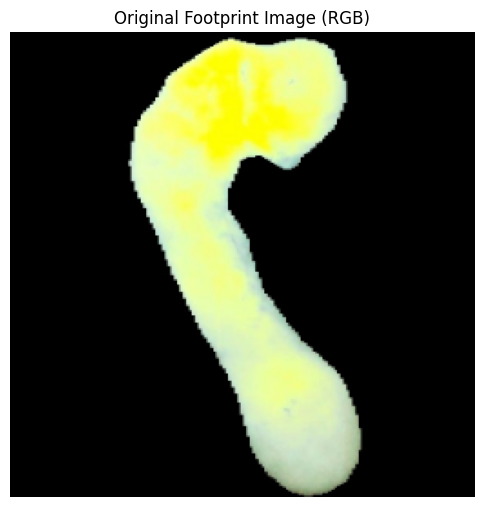

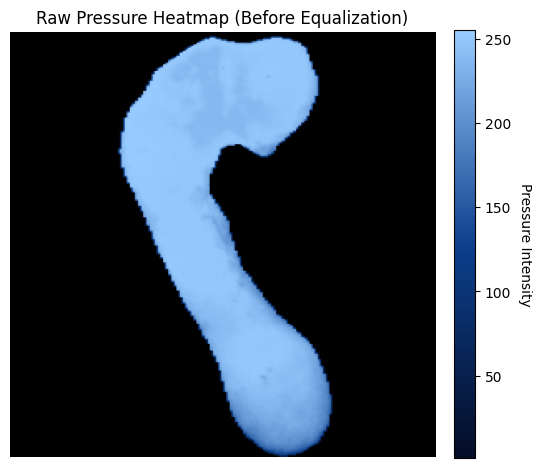

히트맵이 생성되어 'pressure_heatmap_output.png' 에 저장되었습니다.


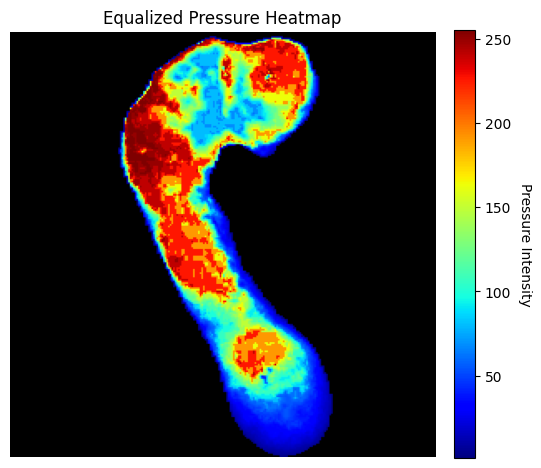

In [86]:
# 예시: 같은 폴더에 있는 Footprint PNG 경로를 지정하세요.
image_path = Path("test_foot_data/0_Original_Source.png_left_256.png")  # TODO: 실제 파일명으로 변경
# image_path = Path("test_foot_data/0_Original_Source.png_right_256.png")

if not image_path.exists():
    raise FileNotFoundError(f"입력 이미지가 존재하지 않습니다: {image_path}")

create_pressure_heatmap(
    image_path=image_path,
    output_path="pressure_heatmap_output.png",
    use_equalization=True,            # Raw + Equalized 둘 다 출력
    background_threshold=10,
    normalization_mode="local",      # 'local' | 'fixed' | 'none'
    fixed_normalization_range=None,   # 필요할 때 (min, max)로 지정
    manual_value_limits=None,         # 컬러 스케일을 직접 고정하고 싶을 때 (vmin, vmax)
    rgb_conversion_mode="grayscale", # 또는 'jet' (Jet 역변환)
    preserve_jet_intensity=True,
)
